## imports

In [2]:
import sagemaker

## clients

In [3]:
sagemaker_session = sagemaker.Session()

In [4]:
role = sagemaker.get_execution_role()

## constants

In [5]:
REGION = "us-east-1"
BUCKET = "sagemaker-us-east-1-180797159824"
S3_OUTPUT_OBJECT_KEY = f"s3://{BUCKET}/output"
INSTANCE_TYPE = "ml.g4dn.4xlarge"
SOLUTION_PREFIX = "sagemaker-soln-odbs-js-geso2g"
NUM_CLASSES = 200
NUM_EPOCHS = 10
NUM_TRAINING_SAMPLES = 4795
TRAIN_CHANNEL = "train"
VALIDATION_CHANNEL = "validation"
S3_TRAIN_OBJECT_KEY = f"s3://{BUCKET}/{TRAIN_CHANNEL}"
S3_VALIDATION_OBJECT_KEY = f"s3://{BUCKET}/{VALIDATION_CHANNEL}"

## Download Model Image

In [6]:
training_image = sagemaker.image_uris.retrieve(region=REGION, framework="object-detection", version="latest")

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


## Create the Estimator

In [7]:
estimator = sagemaker.estimator.Estimator(
    training_image,
    role,
    instance_count=1,
    instance_type=INSTANCE_TYPE,
    volume_size=50,
    max_run=360000,
    input_mode="File",
    output_path=S3_OUTPUT_OBJECT_KEY,
    sagemaker_session=sagemaker_session,
    base_job_name=f"{SOLUTION_PREFIX}-training"
)

## Set the hyperparameters

In [8]:
estimator.set_hyperparameters(
    base_network="resnet-50",
    use_pretrained_model=1,
    num_classes=NUM_CLASSES,
    mini_batch_size=16,
    epochs=NUM_EPOCHS,
    learning_rate=0.001,
    lr_scheduler_step="33,67",
    lr_scheduler_factor=0.1,
    optimizer="sgd",
    momentum=0.9,
    weight_decay=0.0005,
    overlap_threshold=0.5,
    nms_threshold=0.45,
    image_shape=512,
    label_width=350,
    num_training_samples=NUM_TRAINING_SAMPLES,
)

## Prepare the training input

In [9]:
train_data = sagemaker.inputs.TrainingInput(
    S3_TRAIN_OBJECT_KEY,
    distribution="FullyReplicated",
    content_type="application/x-recordio",
    s3_data_type="S3Prefix",
)
validation_data = sagemaker.inputs.TrainingInput(
    S3_VALIDATION_OBJECT_KEY,
    distribution="FullyReplicated",
    content_type="application/x-recordio",
    s3_data_type="S3Prefix",
)
estimator_inputs = {TRAIN_CHANNEL: train_data, VALIDATION_CHANNEL: validation_data}

## Submit the training job

In [ ]:
%%time
estimator.fit(inputs=estimator_inputs, logs=True)

INFO:sagemaker:Creating training-job with name: sagemaker-soln-odbs-js-geso2g-training-2023-05-10-16-12-35-427


2023-05-10 16:12:35 Starting - Starting the training job...
2023-05-10 16:12:50 Starting - Preparing the instances for training......
2023-05-10 16:14:00 Downloading - Downloading input data...
2023-05-10 16:14:20 Training - Downloading the training image...............
2023-05-10 16:17:06 Training - Training image download completed. Training in progress......Docker entrypoint called with argument(s): train
Running default environment configuration script
Nvidia gpu devices, drivers and cuda toolkit versions (only available on hosts with GPU):
Wed May 10 16:17:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                

#### View the training job in AWS SageMaker training jobs

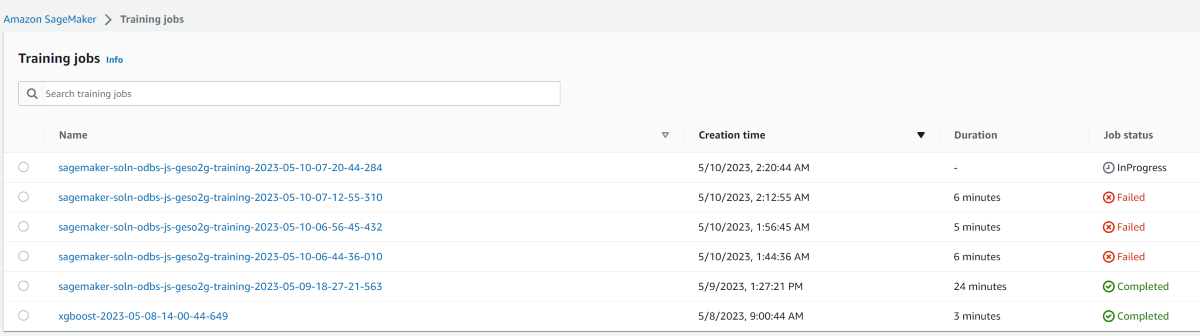

#### View the logs in cloudwatch

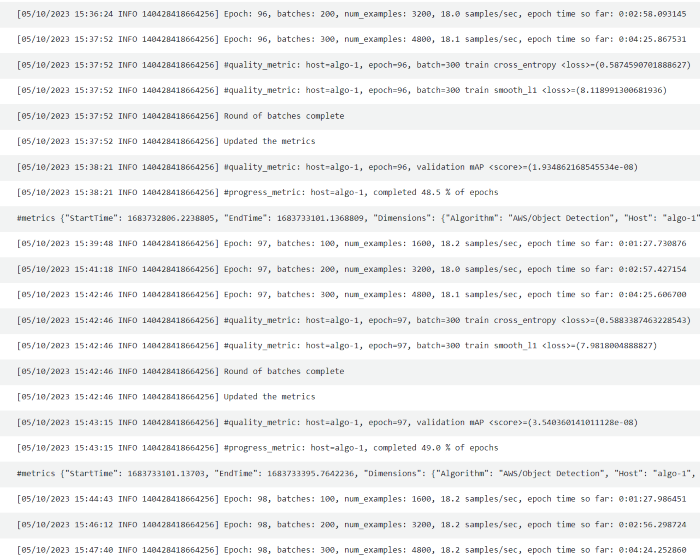

## Deploy the model

In [ ]:
%%time
estimator.deploy(
    endpoint_name=f"{SOLUTION_PREFIX}-endpoint",
    model_name=f"{SOLUTION_PREFIX}-training",
    initial_instance_count=1,
    instance_type="ml.m5.xlarge",
)